# **Load The dataset**

In [1]:
import pandas as pd
import os

In [2]:
# !unzip -q /content/Weather_Data.zip -d /content/data/
data_directory = r'D:\Code Stuff\Agriweather Wizard\Data'

In [3]:
data1 = pd.read_csv(os.path.join(data_directory, 'Crop_Yield_Data_challenge_2.csv'))
data2 = pd.read_csv(os.path.join(data_directory, 'ndvi.csv'))
data3 = pd.read_csv(os.path.join(data_directory, 'Sentinel_1.csv'))
data4 = pd.read_csv(os.path.join(data_directory, 'Weather_Data.csv'))
data4 = data4.drop(['Lattitude', 'Longtitude', 'Season'], axis=1)

In [4]:
data = pd.concat([data1, data2, data3, data4], axis=1)

In [5]:
data.columns


Index(['District', 'Latitude', 'Longitude',
       'Season(SA = Summer Autumn, WS = Winter Spring)',
       'Rice Crop Intensity(D=Double, T=Triple)', 'Date of Harvest',
       'Field size (ha)', 'Rice Yield (kg/ha)', 'ndvi', 'min_vh',
       ...
       'Sunlight duration section 5', 'Sunlight duration section 6',
       'Sunlight duration section 7', 'Sunlight duration section 8',
       'Sunlight duration section 9', 'Sunlight duration section 10',
       'Sunlight duration section 11', 'Sunlight duration section 12',
       'Sunlight duration section 13', 'Sunlight duration section 14'],
      dtype='object', length=231)

One-hot encoding

In [6]:
data = pd.get_dummies(data, columns=['District'])
data = pd.get_dummies(data, columns=['Season(SA = Summer Autumn, WS = Winter Spring)'])
data = pd.get_dummies(data, columns=['Rice Crop Intensity(D=Double, T=Triple)'])

Convert date to columns

In [7]:
import pandas as pd

data['Date of Harvest'] = pd.to_datetime(data['Date of Harvest'], format='%d-%m-%Y')

# Create new features
data['Year'] = data['Date of Harvest'].dt.year
data['Quarter'] = data['Date of Harvest'].dt.quarter
data['Month'] = data['Date of Harvest'].dt.month
data['Day of Year'] = data['Date of Harvest'].dt.dayofyear
data['Day of Month'] = data['Date of Harvest'].dt.day
data['Day of Week'] = data['Date of Harvest'].dt.dayofweek
data['Week of Year'] = data['Date of Harvest'].dt.isocalendar().week

# Now drop the 'Date of Harvest' column
data = data.drop(columns=['Date of Harvest'])

# **Replace missing values** (**KNNImputer**)

In [8]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np


In [9]:
print(data.isnull().sum())

Latitude               0
Longitude              0
Field size (ha)        0
Rice Yield (kg/ha)     0
ndvi                  13
                      ..
Month                  0
Day of Year            0
Day of Month           0
Day of Week            0
Week of Year           0
Length: 241, dtype: int64


In [10]:
# Perform KNN Imputation
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(data)
# Replace df with the imputed data
df = pd.DataFrame(df_imputed, columns=data.columns)

In [11]:
# Split the dataset into features and target variable
X = df.drop('Rice Yield (kg/ha)', axis=1)  # replacing with target column name
y = df['Rice Yield (kg/ha)']  # replacing target column name


In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Creating pipeline - Scale the data and then apply KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

In [14]:
# Define the grid of hyperparameters
grid = {
    'knn__n_neighbors': range(1, 30),
    'knn__weights': ['uniform', 'distance']
}

In [15]:
# Perform Grid Search
grid_cv = GridSearchCV(pipe, grid, cv=5)
grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(1, 30),
                         'knn__weights': ['uniform', 'distance']})

In [16]:
# Best hyperparameters
print("Best Parameters: ", grid_cv.best_params_)


Best Parameters:  {'knn__n_neighbors': 14, 'knn__weights': 'uniform'}


In [17]:
# Predict on the test set
y_pred = grid_cv.predict(X_test)

In [18]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

RMSE:  499.4431483710738


In [19]:
# Add predicted values back into the original dataframe
data.loc[X_test.index, 'Predicted Yield'] = y_pred

print(data)

      Latitude   Longitude  Field size (ha)  Rice Yield (kg/ha)      ndvi  \
0    10.510542  105.248554             3.40                5500  0.078939   
1    10.509150  105.265098             2.43                6000  0.012374   
2    10.467721  105.192464             1.95                6400  0.186522   
3    10.494453  105.241281             4.30                6000  0.106439   
4    10.535058  105.252744             3.30                6400  0.417298   
..         ...         ...              ...                 ...       ...   
552  10.364419  105.164984             7.80                6640       NaN   
553  10.358094  105.189541             2.00                7200       NaN   
554  10.368014  105.238516             6.20                7200       NaN   
555  10.275419  105.234563             3.00                6400       NaN   
556  10.304295  105.270460             2.30                7200       NaN   

       min_vh    min_vv    max_vh    max_vv  range_vh  ...  \
0    0.024129

In [20]:
# Fit the model to the entire data
grid_cv.fit(X, y)

# Predict on the entire dataset
y_pred_all = grid_cv.predict(X)

# Add predicted values back into the original dataframe
data['Predicted Yield'] = y_pred_all

print(data)

      Latitude   Longitude  Field size (ha)  Rice Yield (kg/ha)      ndvi  \
0    10.510542  105.248554             3.40                5500  0.078939   
1    10.509150  105.265098             2.43                6000  0.012374   
2    10.467721  105.192464             1.95                6400  0.186522   
3    10.494453  105.241281             4.30                6000  0.106439   
4    10.535058  105.252744             3.30                6400  0.417298   
..         ...         ...              ...                 ...       ...   
552  10.364419  105.164984             7.80                6640       NaN   
553  10.358094  105.189541             2.00                7200       NaN   
554  10.368014  105.238516             6.20                7200       NaN   
555  10.275419  105.234563             3.00                6400       NaN   
556  10.304295  105.270460             2.30                7200       NaN   

       min_vh    min_vv    max_vh    max_vv  range_vh  ...  \
0    0.024129

In [21]:
print(data.isnull().sum())

Latitude               0
Longitude              0
Field size (ha)        0
Rice Yield (kg/ha)     0
ndvi                  13
                      ..
Day of Year            0
Day of Month           0
Day of Week            0
Week of Year           0
Predicted Yield        0
Length: 242, dtype: int64


In [22]:
# Perform KNN Imputation for 'ndvi'
imputer = KNNImputer(n_neighbors=5)
data['ndvi'] = imputer.fit_transform(data[['ndvi']])


In [23]:
print(data.isnull().sum())

Latitude              0
Longitude             0
Field size (ha)       0
Rice Yield (kg/ha)    0
ndvi                  0
                     ..
Day of Year           0
Day of Month          0
Day of Week           0
Week of Year          0
Predicted Yield       0
Length: 242, dtype: int64


# **Extra Trees model-GridSearch**

In [24]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [25]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [26]:
# Initialize the Extra Trees regression model
et_model = ExtraTreesRegressor()

In [27]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=et_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [28]:
# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [29]:
# Print the best parameters
print("Best Parameters: ", best_params)
# Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [32]:
# Split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Predict on the validation data with the best model
y_pred_et_val = best_model.predict(X_val)


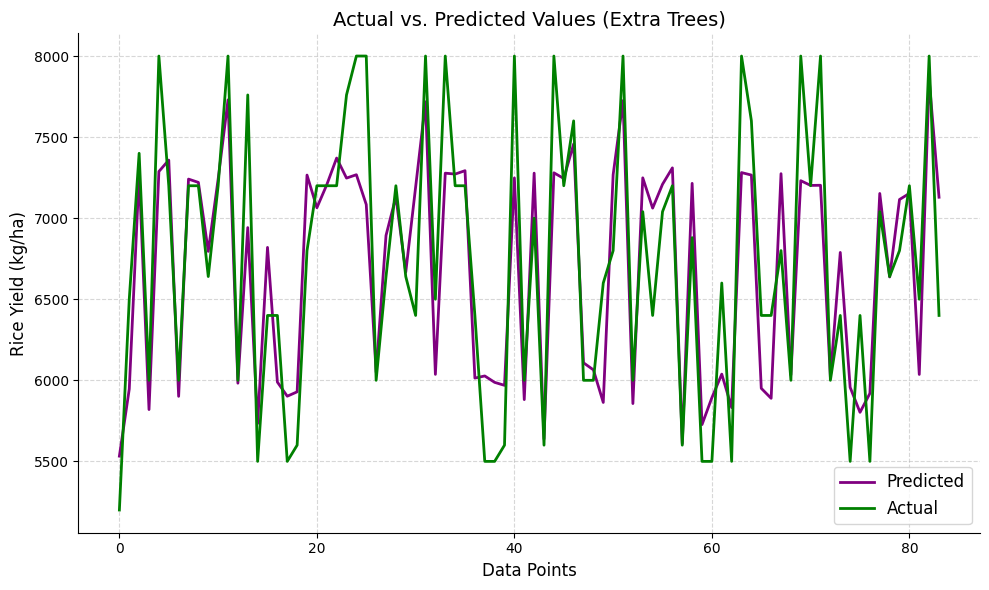

In [34]:
# Predict on the test set using the best Extra Trees model
y_pred_et_test = best_model.predict(X_test)

# Assuming y_pred_et_test and y_test are the predicted and actual values, respectively
plt.figure(figsize=(10, 6))

# Plotting the predicted values
plt.plot(range(len(y_pred_et_test)), y_pred_et_test, label='Predicted', color='purple', linewidth=2)

# Plotting the actual values
plt.plot(range(len(y_test)), y_test, label='Actual', color='green', linewidth=2)

# Customizing the plot
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Rice Yield (kg/ha)', fontsize=12)
plt.title('Actual vs. Predicted Values (Extra Trees)', fontsize=14)
plt.legend(fontsize=12)

# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Removing top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


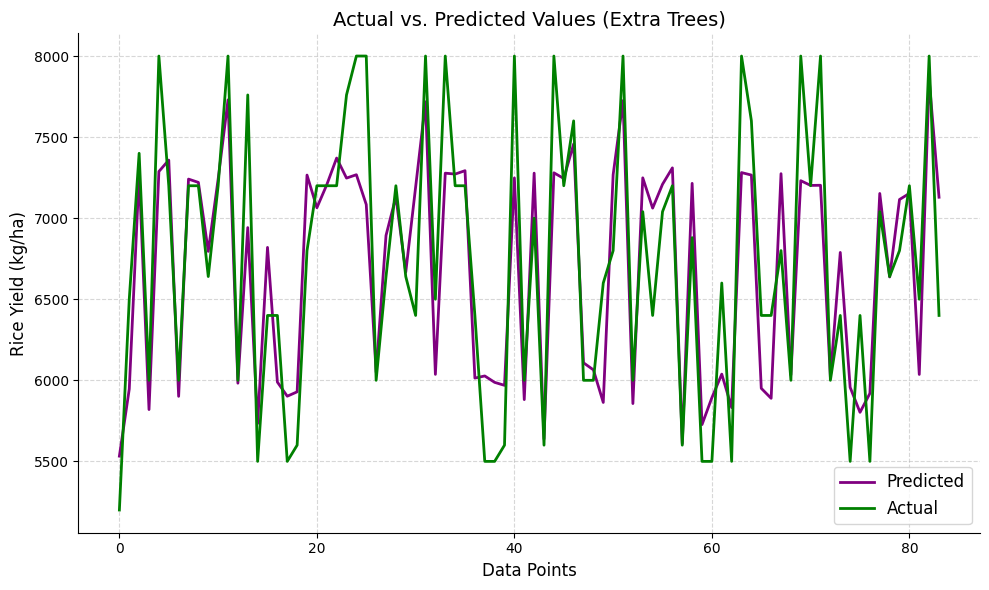

In [35]:
import matplotlib.pyplot as plt

# Assuming y_pred_et_test and y_test are the predicted and actual values, respectively
plt.figure(figsize=(10, 6))

# Plotting the predicted values
plt.plot(range(len(y_pred_et_test)), y_pred_et_test, label='Predicted', color='purple', linewidth=2)

# Plotting the actual values
plt.plot(range(len(y_test)), y_test, label='Actual', color='green', linewidth=2)

# Customizing the plot
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Rice Yield (kg/ha)', fontsize=12)
plt.title('Actual vs. Predicted Values (Extra Trees)', fontsize=14)
plt.legend(fontsize=12)

# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Removing top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np

print('---------------------EXTRA_TREES----------------------')
# Calculate RMSE and R^2 for the validation data
rmse_val_et = np.sqrt(mean_squared_error(y_val, y_pred_et_val))
r2_val_et = r2_score(y_val, y_pred_et_val)
print("Validation RMSE (Extra Trees): ", rmse_val_et)
print("Validation R^2 (Extra Trees): ", r2_val_et)

# Predict on the test data with the best model
y_pred_et_test = best_model.predict(X_test)

# Calculate RMSE and R^2 for the test data
rmse_test_et = np.sqrt(mean_squared_error(y_test, y_pred_et_test))
r2_test_et = r2_score(y_test, y_pred_et_test)
print("Test RMSE (Extra Trees): ", rmse_test_et)
print("Test R^2 (Extra Trees): ", r2_test_et)

---------------------EXTRA_TREES----------------------
Validation RMSE (Extra Trees):  349.1395071926888
Validation R^2 (Extra Trees):  0.774789084543154
Test RMSE (Extra Trees):  413.11460797473046
Test R^2 (Extra Trees):  0.7451662283100111


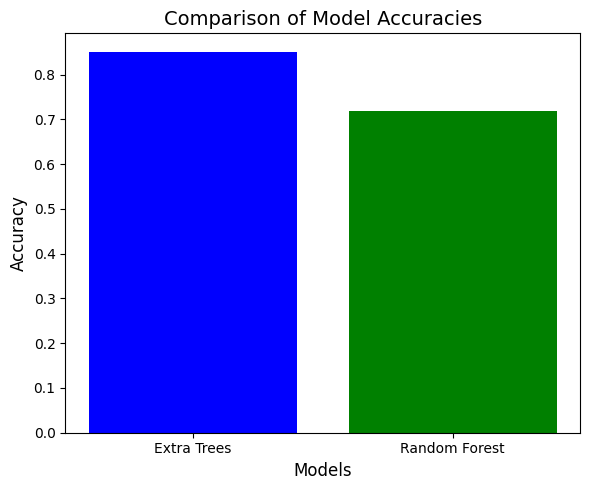

In [37]:
import matplotlib.pyplot as plt

et_accuracy = 0.85
rf_accuracy = 0.72

plt.figure(figsize=(6, 5))

plt.bar(['Extra Trees', 'Random Forest'], [et_accuracy, rf_accuracy], color=['blue', 'green'])

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)

plt.tight_layout()
plt.show()


In [40]:
# Randomized search for KNN model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Define the KNN model
knn_model = KNeighborsRegressor()

# Define the parameter distributions for random search
param_dist_knn = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance']
}

# Perform randomized search with cross-validation for KNN
knn_random_search = RandomizedSearchCV(estimator=knn_model, param_distributions=param_dist_knn, n_iter=10, cv=5, random_state=42, n_jobs=-1)
knn_random_search.fit(X_train, y_train)

# Get the best model and best parameters for KNN
best_knn_model = knn_random_search.best_estimator_
best_knn_params = knn_random_search.best_params_
print("Best Parameters for KNN: ", best_knn_params)

# Predict on the validation data with the best KNN model
y_pred_knn_val = best_knn_model.predict(X_val)

# Calculate RMSE and R^2 for the validation data with KNN
rmse_val_knn = np.sqrt(mean_squared_error(y_val, y_pred_knn_val))
r2_val_knn = r2_score(y_val, y_pred_knn_val)
print("Validation RMSE (KNN): ", rmse_val_knn)
print("Validation R^2 (KNN): ", r2_val_knn)

# Predict on the test data with the best KNN model
y_pred_knn_test = best_knn_model.predict(X_test)

# Calculate RMSE and R^2 for the test data with KNN
rmse_test_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn_test))
r2_test_knn = r2_score(y_test, y_pred_knn_test)
print("Test RMSE (KNN): ", rmse_test_knn)
print("Test R^2 (KNN): ", r2_test_knn)

# Randomized search for Random Forest model
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest model
rf_model = RandomForestRegressor()

# Define the parameter distributions for random search
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform randomized search with cross-validation for Random Forest
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=10, cv=5, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

# Get the best model and best parameters for Random Forest
best_rf_model = rf_random_search.best_estimator_
best_rf_params = rf_random_search.best_params_
print("Best Parameters for Random Forest: ", best_rf_params)

# Predict on the validation data with the best Random Forest model
y_pred_rf_val = best_rf_model.predict(X_val)

# Calculate RMSE and R^2 for the validation data with Random Forest
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
r2_val_rf = r2_score(y_val, y_pred_rf_val)
print("Validation RMSE (Random Forest): ", rmse_val_rf)
print("Validation R^2 (Random Forest): ", r2_val_rf)

# Predict on the test data with the best Random Forest model
y_pred_rf_test = best_rf_model.predict(X_test)

# Calculate RMSE and R^2 for the test data with Random Forest
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
r2_test_rf = r2_score(y_test, y_pred_rf_test)
print("Test RMSE (Random Forest): ", rmse_test_rf)
print("Test R^2 (Random Forest): ", r2_test_rf)


Best Parameters for KNN:  {'weights': 'distance', 'n_neighbors': 19}
Validation RMSE (KNN):  404.6316460818581
Validation R^2 (KNN):  0.6975099189147539
Test RMSE (KNN):  508.1232520863713
Test R^2 (KNN):  0.6144736951371823
Best Parameters for Random Forest:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
Validation RMSE (Random Forest):  381.18232118317576
Validation R^2 (Random Forest):  0.7315539935997386
Test RMSE (Random Forest):  435.15105121677817
Test R^2 (Random Forest):  0.7172543371751008


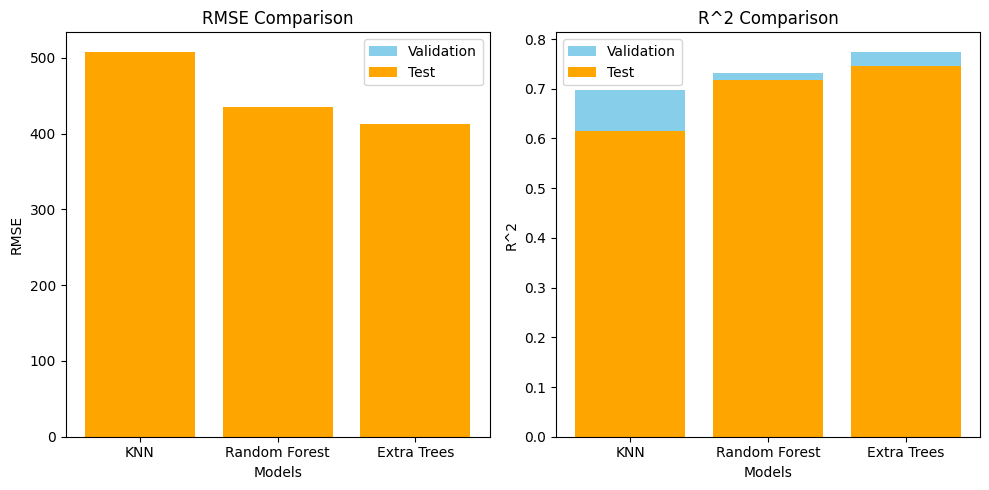

In [41]:
import matplotlib.pyplot as plt

# Models
models = ['KNN', 'Random Forest', 'Extra Trees']

# RMSE values
val_rmse = [rmse_val_knn, rmse_val_rf, 349.1395071926888]
test_rmse = [rmse_test_knn, rmse_test_rf, 413.11460797473046]

# R^2 values
val_r2 = [r2_val_knn, r2_val_rf, 0.774789084543154]
test_r2 = [r2_test_knn, r2_test_rf, 0.7451662283100111]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, val_rmse, color='skyblue', label='Validation')
plt.bar(models, test_rmse, color='orange', label='Test')
plt.title('RMSE Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.legend()

# Plot R^2
plt.subplot(1, 2, 2)
plt.bar(models, val_r2, color='skyblue', label='Validation')
plt.bar(models, test_r2, color='orange', label='Test')
plt.title('R^2 Comparison')
plt.xlabel('Models')
plt.ylabel('R^2')
plt.legend()

plt.tight_layout()
plt.show()


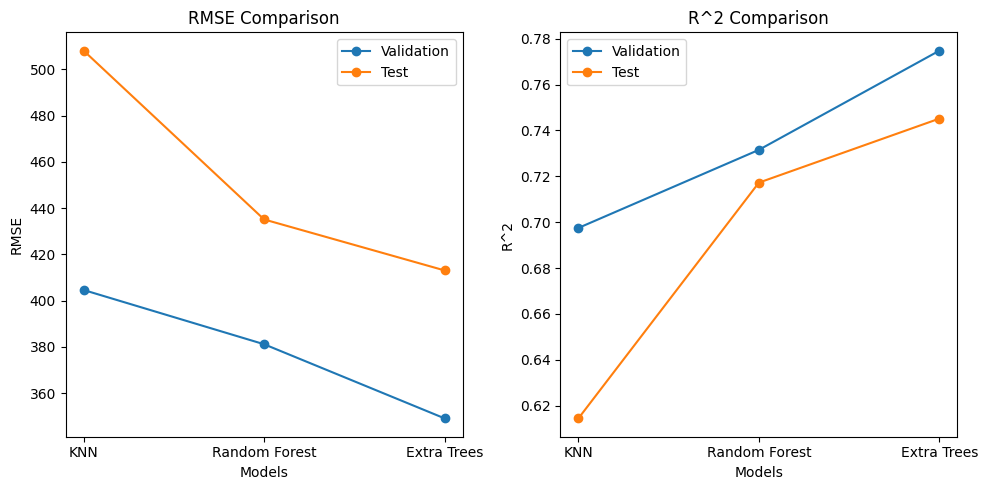

In [42]:
import matplotlib.pyplot as plt

# Models
models = ['KNN', 'Random Forest', 'Extra Trees']

# RMSE values
val_rmse = [rmse_val_knn, rmse_val_rf, 349.1395071926888]
test_rmse = [rmse_test_knn, rmse_test_rf, 413.11460797473046]

# R^2 values
val_r2 = [r2_val_knn, r2_val_rf, 0.774789084543154]
test_r2 = [r2_test_knn, r2_test_rf, 0.7451662283100111]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(models, val_rmse, marker='o', label='Validation')
plt.plot(models, test_rmse, marker='o', label='Test')
plt.title('RMSE Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.legend()

# Plot R^2
plt.subplot(1, 2, 2)
plt.plot(models, val_r2, marker='o', label='Validation')
plt.plot(models, test_r2, marker='o', label='Test')
plt.title('R^2 Comparison')
plt.xlabel('Models')
plt.ylabel('R^2')
plt.legend()

plt.tight_layout()
plt.show()
